In [1]:
import sys, importlib
sys.path.append('../')

from Modules.Utils.Imports import *

from Modules.Models.BuildSurfaceFitter import BuildSurfaceFitter
from Modules.Utils.Gradient import Gradient
from Modules.Utils.ModelWrapper import ModelWrapper

In [2]:
device = torch.device(GetLowestGPU(pick_from=[]))

Device set to cpu


# Save surface data and plot residuals

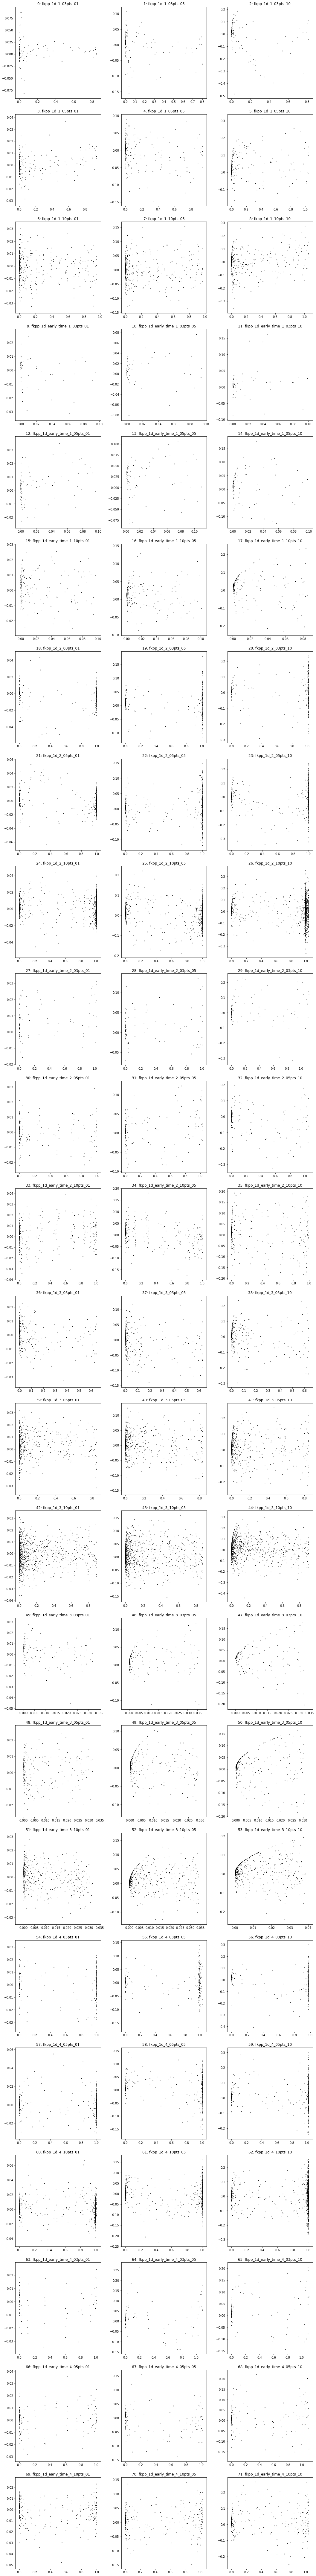

In [3]:
plot = True
save = False

# 2D Fisher KPP
path = '../../Data/Surfaces/FKPP1D/'
#files = glob.glob(path+'fkpp_1d_param_sweep*.npy')
#files += glob.glob(path+'fkpp_1d_early_time_param_sweep*.npy')
#files = [os.path.basename(file) for file in files]
#files.sort()
files = [
    'fkpp_1d_1_03pts_01.npy','fkpp_1d_1_03pts_05.npy','fkpp_1d_1_03pts_10.npy',
    'fkpp_1d_1_05pts_01.npy','fkpp_1d_1_05pts_05.npy','fkpp_1d_1_05pts_10.npy',
    'fkpp_1d_1_10pts_01.npy','fkpp_1d_1_10pts_05.npy','fkpp_1d_1_10pts_10.npy',
    'fkpp_1d_early_time_1_03pts_01.npy','fkpp_1d_early_time_1_03pts_05.npy','fkpp_1d_early_time_1_03pts_10.npy',
    'fkpp_1d_early_time_1_05pts_01.npy','fkpp_1d_early_time_1_05pts_05.npy','fkpp_1d_early_time_1_05pts_10.npy',
    'fkpp_1d_early_time_1_10pts_01.npy','fkpp_1d_early_time_1_10pts_05.npy','fkpp_1d_early_time_1_10pts_10.npy',
    'fkpp_1d_2_03pts_01.npy','fkpp_1d_2_03pts_05.npy','fkpp_1d_2_03pts_10.npy',
    'fkpp_1d_2_05pts_01.npy','fkpp_1d_2_05pts_05.npy','fkpp_1d_2_05pts_10.npy',
    'fkpp_1d_2_10pts_01.npy','fkpp_1d_2_10pts_05.npy','fkpp_1d_2_10pts_10.npy',
    'fkpp_1d_early_time_2_03pts_01.npy','fkpp_1d_early_time_2_03pts_05.npy','fkpp_1d_early_time_2_03pts_10.npy',
    'fkpp_1d_early_time_2_05pts_01.npy','fkpp_1d_early_time_2_05pts_05.npy','fkpp_1d_early_time_2_05pts_10.npy',
    'fkpp_1d_early_time_2_10pts_01.npy','fkpp_1d_early_time_2_10pts_05.npy','fkpp_1d_early_time_2_10pts_10.npy',
    'fkpp_1d_3_03pts_01.npy','fkpp_1d_3_03pts_05.npy','fkpp_1d_3_03pts_10.npy',
    'fkpp_1d_3_05pts_01.npy','fkpp_1d_3_05pts_05.npy','fkpp_1d_3_05pts_10.npy',
    'fkpp_1d_3_10pts_01.npy','fkpp_1d_3_10pts_05.npy','fkpp_1d_3_10pts_10.npy',
    'fkpp_1d_early_time_3_03pts_01.npy','fkpp_1d_early_time_3_03pts_05.npy','fkpp_1d_early_time_3_03pts_10.npy',
    'fkpp_1d_early_time_3_05pts_01.npy','fkpp_1d_early_time_3_05pts_05.npy','fkpp_1d_early_time_3_05pts_10.npy',
    'fkpp_1d_early_time_3_10pts_01.npy','fkpp_1d_early_time_3_10pts_05.npy','fkpp_1d_early_time_3_10pts_10.npy',
    'fkpp_1d_4_03pts_01.npy','fkpp_1d_4_03pts_05.npy','fkpp_1d_4_03pts_10.npy',
    'fkpp_1d_4_05pts_01.npy','fkpp_1d_4_05pts_05.npy','fkpp_1d_4_05pts_10.npy',
    'fkpp_1d_4_10pts_01.npy','fkpp_1d_4_10pts_05.npy','fkpp_1d_4_10pts_10.npy',
    'fkpp_1d_early_time_4_03pts_01.npy','fkpp_1d_early_time_4_03pts_05.npy','fkpp_1d_early_time_4_03pts_10.npy',
    'fkpp_1d_early_time_4_05pts_01.npy','fkpp_1d_early_time_4_05pts_05.npy','fkpp_1d_early_time_4_05pts_10.npy',
    'fkpp_1d_early_time_4_10pts_01.npy','fkpp_1d_early_time_4_10pts_05.npy','fkpp_1d_early_time_4_10pts_10.npy']

# build surface fitter
surface_fitter = BuildSurfaceFitter(
    input_variables=2, 
    hidden_layers=[256, 256, 256], 
    output_variables=1, 
    activations=[nn.Sigmoid()],
    output_activation=nn.Softplus()) 
surface_fitter = surface_fitter.to(device)
model = ModelWrapper(
    surface_fitter,
    optimizer=None,
    loss=None,
    save_opt=False)

# data normalizer
def normalize(x):
    x_min = np.min(x)
    x -= x_min
    x_max = np.max(x)
    x /= x_max
    return x, x_min, x_max

# keep a count to see if anything needs retraining
count = 0

# loop over each surface
fig = plt.figure(figsize=(5*3,5*int(np.ceil(len(files)/3))))
for file_index in range(len(files)):
    
    #if count != 0:
    #    count += 1
    #    continue
    
    #start, stop = 0, 2
    #if count < start or count > stop:
    #    count += 1
    #    continue
    
    # load data
    file_name = files[file_index]
    file = np.load(path + file_name, allow_pickle=True, encoding='latin1').item()
    inputs = file['inputs']
    shapes = file['shape']
    outputs = file['outputs']
    gamma = file['gamma']
    #print(shapes, inputs.shape, outputs.shape)
    
    # normalize
    x = inputs[:, 0].astype(np.float)
    x, x_min, x_max = normalize(x)
    t = inputs[:, 1].astype(np.float)
    t, t_min, t_max = normalize(t)
    u = outputs[:, 0].astype(np.float)
    
    # convert to inputs and outputs
    inputs = np.concatenate([x[:, None], 
                             t[:, None]], axis=1)
    outputs = u[:, np.newaxis]
    
    # convert to torch
    def numpy_to_tensor(ndarray):
        arr = torch.tensor(ndarray, dtype=torch.float)
        arr.requires_grad_(True)
        arr = arr.to(device)
        return arr
    inputs = numpy_to_tensor(inputs)
    outputs = numpy_to_tensor(outputs)
    
    # load model weights
    model.save_name = '../Weights/FKPP1D/'+file_name[:-4]
    model.load_best_val(device=device)
    
    if plot:
        
        # model prediction
        U_pred = surface_fitter(inputs.to(device)).cpu().detach().numpy().reshape(-1)
        U_true = outputs.cpu().detach().numpy().reshape(-1)
        modified_residuals = (U_pred-U_true)/(np.abs(U_pred).clip(1e-10,1)**gamma)

        # plot modified residuals
        ax = fig.add_subplot(int(np.ceil(len(files)/3)), 3, count+1)
        plt.scatter(U_pred, modified_residuals, color='k', s=1)
        plt.title(str(count)+': '+file_name[:-4])
    
    if save:
        
        # predict
        outputs = surface_fitter(inputs)
        d1 = Gradient(outputs, inputs, order=1)
        d1 = [d1[:, i] for i in range(d1.shape[1])]
        d2 = [Gradient(d, inputs, order=1) for d in d1]
        d2 = [d2[i][:, j] for i in range(len(d1)) for j in range(len(d1))]

        # extract and rescale
        x = inputs[:, 0].cpu().detach().numpy() * x_max + x_min
        t = inputs[:, 1].cpu().detach().numpy() * t_max + t_min
        u_pred = outputs.cpu().detach().numpy()
        ux = d1[0].cpu().detach().numpy() / x_max
        ut = d1[1].cpu().detach().numpy() / t_max
        uxx = d2[0].cpu().detach().numpy() / x_max / x_max
        uxt = d2[1].cpu().detach().numpy() / x_max / t_max
        utx = d2[2].cpu().detach().numpy() / t_max / x_max
        utt = d2[3].cpu().detach().numpy() / t_max / t_max

        # store variables
        dictionary = {
            'variables': [x,t,u_pred,ux,ut,uxx,uxt,utx,utt],
            'variable_names': ['x','t','u','ux','ut','uxx','uxt','utx','utt'],
            'shapes': shapes,
            'gamma': gamma
        }
    
        np.save('../Results/'+file_name[:-4]+'_ann', dictionary)
        
        #fig = plt.figure(figsize=(15,5))
        #ax1 = fig.add_subplot(1,4,1)
        #ax2 = fig.add_subplot(1,4,2)
        #ax3 = fig.add_subplot(1,4,3)
        #ax4 = fig.add_subplot(1,4,4)
        #for i in range(len(np.unique(t))):
        #    start = i*shapes[0]
        #    stop = (i+1)*shapes[0]
        #    ax1.plot(x[start:stop], u_pred[start:stop], color=colors[i])
        #    ax1.plot(x[start:stop], u[start:stop], '.', color=colors[i])
        #    ax2.plot(x[start:stop], ut[start:stop], color=colors[i])
        #    ax3.plot(x[start:stop], ux[start:stop], color=colors[i])
        #    ax4.plot(x[start:stop], uxx[start:stop], color=colors[i])
        #ax1.set_ylabel(file_name[:-4])
        #plt.show()
    
    count += 1
    
if plot:
    plt.tight_layout(pad=2)
    plt.show()

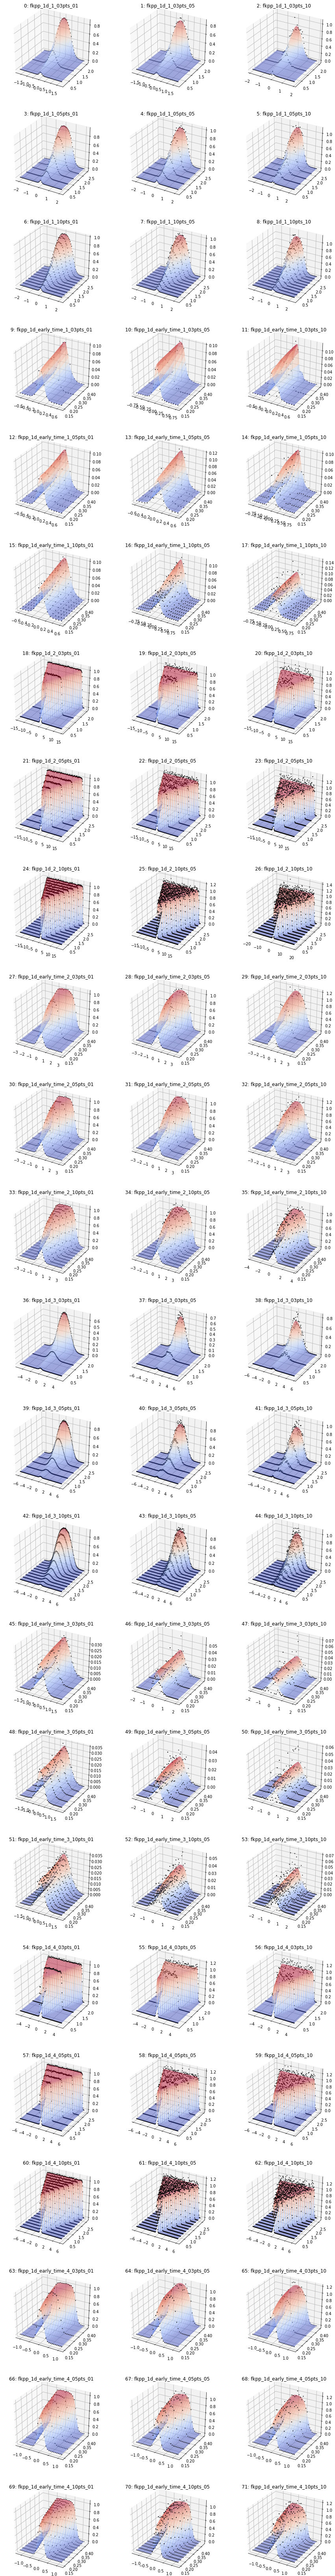

In [4]:
#
# plot individual surface fits
#

# make meshgrid of inputs
x = np.linspace(0,1,100)
X, T = np.meshgrid(x, x, indexing='ij')
inputs = np.concatenate([X.reshape(-1,1), T.reshape(-1,1)], axis=1)
inputs = numpy_to_tensor(inputs)

# loop over each surface
count = 0
fig = plt.figure(figsize=(5*3,5*int(np.ceil(len(files)/3))))
for file_index in range(len(files)):
    
    # only do one data set
    #if count != 14:
    #    count += 1
    #    continue
    
    # only do a range of data sets
    #start, stop = 0, 5
    #if count < start or count > stop:
    #    count += 1
    #    continue

    # load surface fitter
    model.save_name = '../Weights/FKPP1D/'+files[file_index][:-4]
    model.load_best_val(device=device)

    # evaluate surface fitter on meshgrid
    U_pred = surface_fitter(inputs).cpu().detach().numpy().reshape(X.shape)

    # extract inputs and outputs from data
    file = np.load(path + files[file_index], allow_pickle=True, encoding='latin1').item()
    shape = file['shape']
    x = file['inputs'][:, 0].astype(np.float)
    x, x_min, x_max = normalize(x)
    t = file['inputs'][:, 1].astype(np.float)
    t, t_min, t_max = normalize(t)
    u = file['outputs'][:, 0].astype(np.float)

    # scale variables out
    x = x*x_max + x_min
    t = t*t_max + t_min

    # plot
    skip = 1
    ax = fig.add_subplot(int(np.ceil(len(files)/3)), 3, count+1, projection='3d')
    ax.plot_surface(X*x_max + x_min, T*t_max + t_min, U_pred, cmap=cm.coolwarm, alpha=0.5)
    ax.scatter(x[::skip], t[::skip], u[::skip], s=2, c='k')
    plt.title(str(count)+': '+files[file_index][:-4])
    count += 1
    
plt.show()

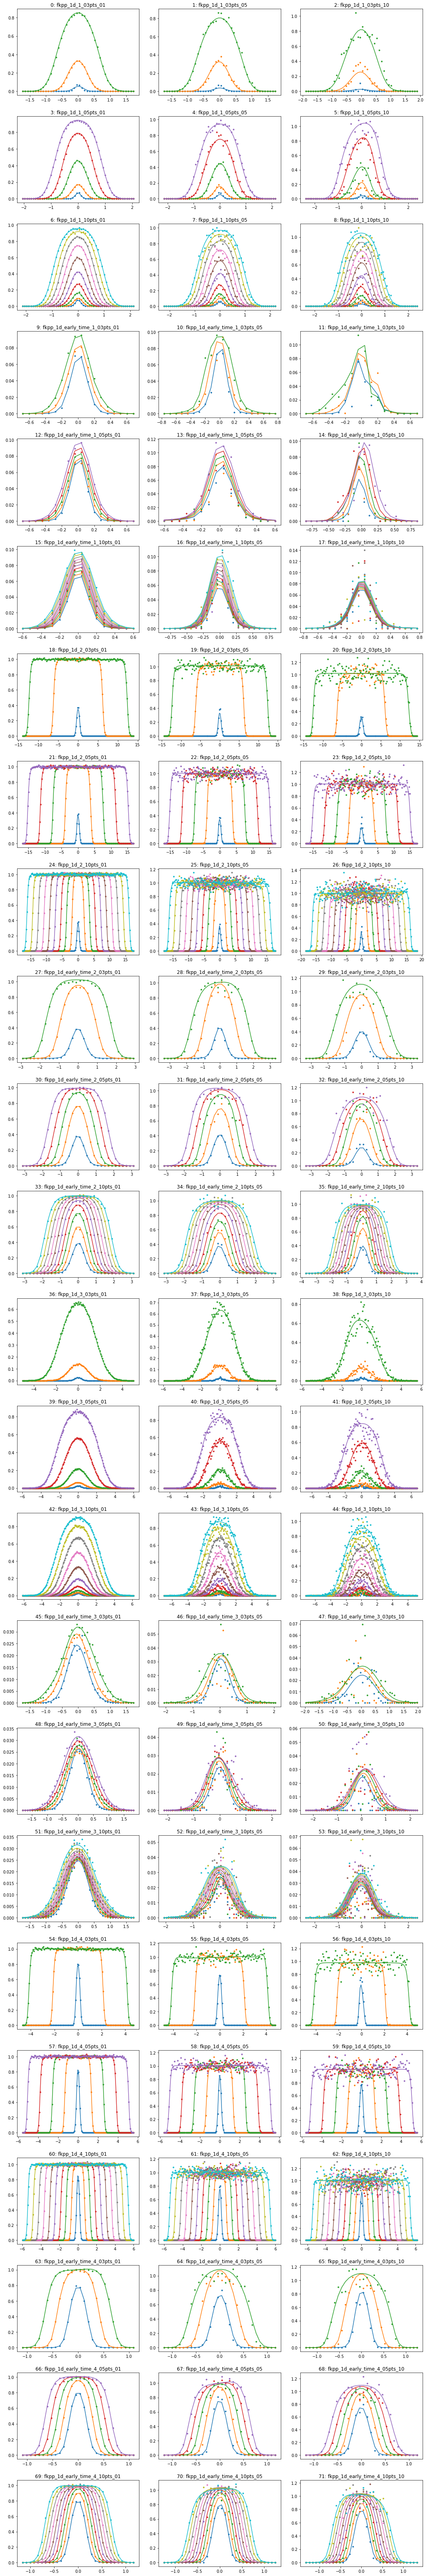

In [5]:
#
# plot time series
#

# loop over each surface
count = 0
fig = plt.figure(figsize=(5*3,5*18))
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
for file_index in range(len(files)):
    
    # only do one data set
    #if count != 0:
    #    count += 1
    #    continue
    
    # only do a range of data sets
    #start, stop = 0, 5
    #if count < start or count > stop:
    #    count += 1
    #    continue
    
    # load data
    file_name = files[file_index]
    file = np.load(path + file_name, allow_pickle=True, encoding='latin1').item()
    inputs = file['inputs']
    shapes = file['shape']
    outputs = file['outputs']
    
    # normalize
    x = inputs[:, 0].astype(np.float)
    x, x_min, x_max = normalize(x)
    t = inputs[:, 1].astype(np.float)
    t, t_min, t_max = normalize(t)
    u = outputs[:, 0].astype(np.float)
    
    # convert to inputs and outputs
    inputs = np.concatenate([x[:, np.newaxis], 
                             t[:, np.newaxis]], axis=1)
    
    # convert to torch
    def numpy_to_tensor(ndarray):
        arr = torch.tensor(ndarray, dtype=torch.float)
        arr.requires_grad_(True)
        arr = arr.to(device)
        return arr
    inputs = numpy_to_tensor(inputs)
    
    # load model weights
    model.save_name = '../Weights/FKPP1D/'+file_name[:-4]
    model.load_best_val(device=device)
    
    # evaluate surface fitter 
    U_pred = surface_fitter(inputs).cpu().detach().numpy()

    # scale variables out
    x = x*x_max + x_min
    t = t*t_max + t_min

    # plot
    skip = 1
    ax = fig.add_subplot(24, 3, count+1)
    for i in range(len(np.unique(t))):
        start = i*shapes[0]
        stop = (i+1)*shapes[0]
        ax.plot(x[start:stop], U_pred[start:stop], color=colors[i])
        ax.plot(x[start:stop], u[start:stop], '.', color=colors[i])
    plt.title(str(count)+': '+files[file_index][:-4])
    count += 1
    
plt.tight_layout(h_pad=2, w_pad=2)
plt.savefig('../Figures/FKPP1D_ANN_fits.pdf', format='pdf')
plt.show()